In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('earnings_data.csv')
data_og = data

In [3]:
data = pd.get_dummies(data, drop_first=True)

In [4]:
data.head()

,years_of_experience,salary,gender_male,career_se
0,0,47000,1,0
1,0,48000,1,0
2,0,48500,1,0
3,0,50000,1,0
4,0,75000,1,0


In [5]:
data.tail()

,years_of_experience,salary,gender_male,career_se
2525,20,90964,0,1
2526,20,109917,0,1
2527,20,105178,0,1
2528,20,112357,0,1
2529,20,97394,0,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('salary', axis = 1),
                                                    np.log1p(data.salary.values),
                                                    test_size =.30,
                                                    random_state=12345)
dtrain = xgb.DMatrix(data = X_train, label=y_train)
dtest = xgb.DMatrix(data = X_test, label=y_test)
param = {'eta':0.1,
         'objective':'reg:linear'}
xgb_model = xgb.train(param, dtrain, num_boost_round=100)
X_test['y_hat_with_bias'] = np.exp(xgb_model.predict(dtest)) - 1

[09:42:00] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [13]:
X_test.head()

,years_of_experience,gender_male,career_se,y_hat_with_bias
932,9,0,0,78193.265625
936,10,0,0,74248.554688
608,20,1,0,115175.234375
1971,2,0,1,47117.445312
724,3,0,0,66685.921875


In [14]:
se_xt = X_test[X_test['career_se']==1]
consulting_xt = X_test[X_test['career_se']==0]

se_xt.head()

,years_of_experience,gender_male,career_se,y_hat_with_bias
1971,2,0,1,47117.445312
1673,13,1,1,87571.335938
1269,0,1,1,56317.097656
1378,3,1,1,68193.187500
1344,2,1,1,67171.156250


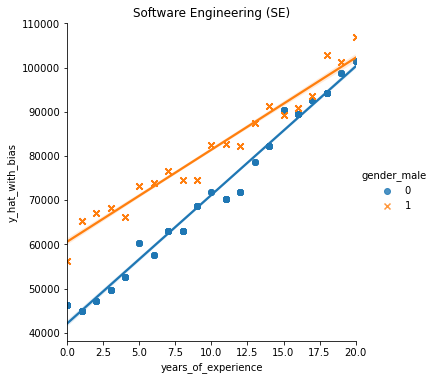

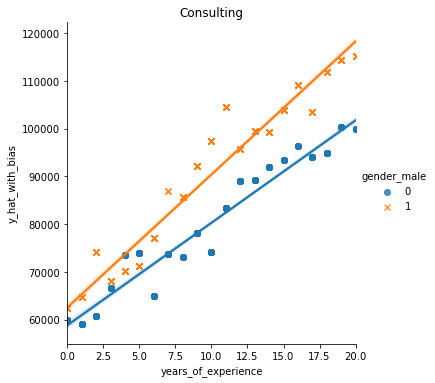

In [15]:
xt_ax1 = sns.lmplot(x="years_of_experience", y="y_hat_with_bias", hue="gender_male",  data=se_xt, markers=["o", "x"],).set(title= 'Software Engineering (SE)');
xt_ax2 = sns.lmplot(x="years_of_experience", y="y_hat_with_bias", hue="gender_male",  data=consulting_xt, markers=["o", "x"],).set(title= 'Consulting');

In [ ]:
#code addapted from: https://seaborn.pydata.org/tutorial/regression.html and https://towardsdatascience.com/preventing-machine-learning-bias-d01adfe9f1fa

In [54]:
#X_test.tail()

,years_of_experience,gender_male,career_se,y_hat_with_bias
598,20,1,0,117048.812500
308,10,1,0,96890.875000
1232,0,1,1,57922.742188
178,5,1,0,71279.656250
1523,9,1,1,93071.265625


In [10]:
sns.set_theme(color_codes=True)
tips = data

In [77]:
tips.head()

,gender,career,years_of_experience,salary
0,male,consulting,0,47000
1,male,consulting,0,48000
2,male,consulting,0,48500
3,male,consulting,0,50000
4,male,consulting,0,75000


In [13]:
se_data = data_og[data_og['career']=='se']
consulting_data = data_og[data_og['career']=='consulting']

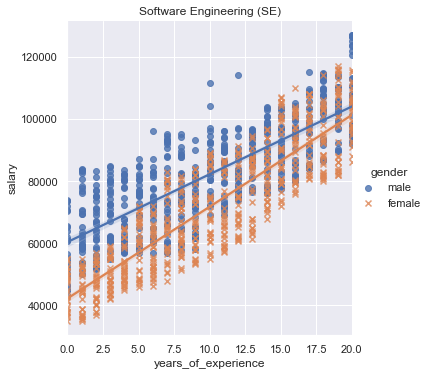

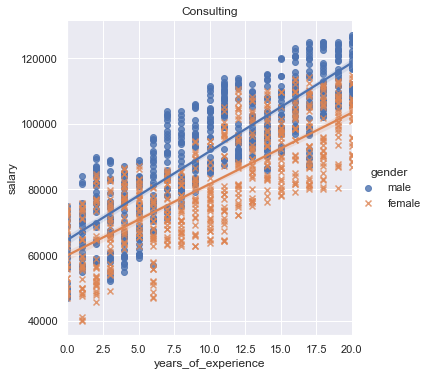

In [40]:
og_ax1 = sns.lmplot(x="years_of_experience", y="salary", hue="gender",  data=se_data, markers=["o", "x"],).set(title= 'Software Engineering (SE)');
og_ax2 = sns.lmplot(x="years_of_experience", y="salary", hue="gender",  data=consulting_data, markers=["o", "x"],).set(title= 'Consulting');

In [15]:
feature_names = dtest.feature_names
interactions = xgb_model.predict(dtest, pred_interactions=True)
pd.DataFrame(interactions[0],
             index = feature_names + ['intercept'],
             columns= feature_names + ['intercept'])

,years_of_experience,gender_male,career_se,intercept
years_of_experience,-0.009326,-0.004744,0.004116,0.00000
gender_male,-0.004744,-0.062185,-0.002717,0.00000
career_se,0.004116,-0.002717,0.069579,0.00000
intercept,0.000000,0.000000,0.000000,11.27558


In [16]:
bias_var = np.array('gender_male')
bias_idx = np.argwhere(np.isin(np.array(feature_names), bias_var))[0]
interactions[:, bias_idx, :] = 0
interactions[:, :, bias_idx] = 0
y_hat_no_bias = np.exp(interactions.sum(axis = 1).sum(axis = 1)) - 1

In [121]:
#X_train.head()

,years_of_experience,gender_male,career_se
765,4,0,0
72,2,1,0
529,17,1,0
919,10,0,0
705,3,0,0


In [17]:
new_df = []
X_test['y_hat_no_bias'] = y_hat_no_bias

In [18]:
X_test.head()

,years_of_experience,gender_male,career_se,y_hat_with_bias,y_hat_no_bias
932,9,0,0,78193.265625,84461.734375
936,10,0,0,74248.554688,84694.437500
608,20,1,0,115175.234375,107835.273438
1971,2,0,1,47117.445312,55738.105469
724,3,0,0,66685.921875,68130.648438


In [19]:
new_df = X_test

In [20]:
new_df['difference'] = new_df["y_hat_with_bias"] - new_df["y_hat_no_bias"]

In [34]:
new_df['salary'] = np.expm1(y_test)

In [35]:
new_df.head()

,years_of_experience,gender_male,career_se,y_hat_with_bias,y_hat_no_bias,difference,salary
932,9,0,0,78193.265625,84461.734375,-6268.468750,82110.0
936,10,0,0,74248.554688,84694.437500,-10445.882812,73423.0
608,20,1,0,115175.234375,107835.273438,7339.960938,111511.0
1971,2,0,1,47117.445312,55738.105469,-8620.660156,41971.0
724,3,0,0,66685.921875,68130.648438,-1444.726562,73991.0


In [27]:
unbias_se_data         = new_df[new_df['career_se']==1]
unbias_consulting_data = new_df[new_df['career_se']==0]

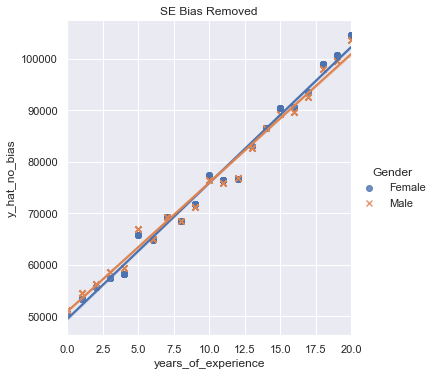

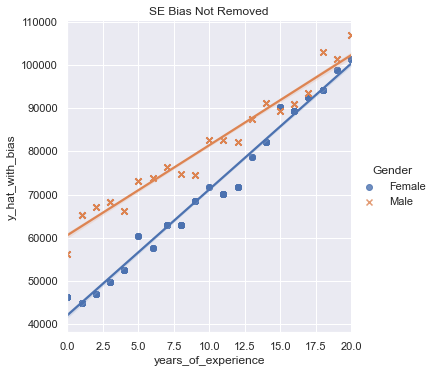

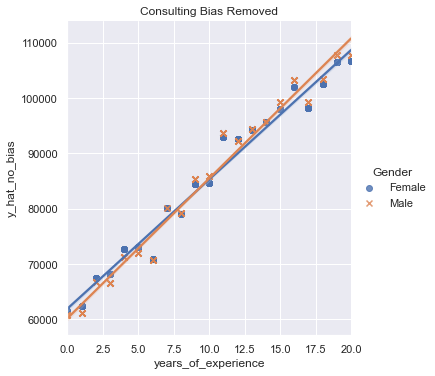

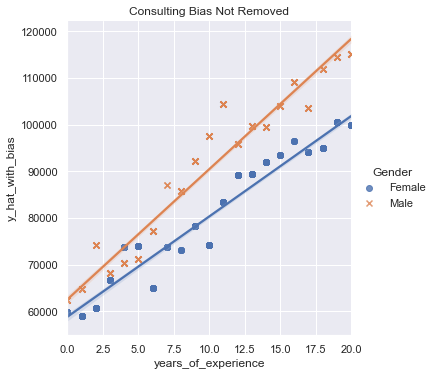

In [38]:
ax1 = sns.lmplot(x="years_of_experience", y="y_hat_no_bias", hue="gender_male", data=unbias_se_data, markers=["o", "x"],);
ax2 = sns.lmplot(x="years_of_experience", y="y_hat_with_bias", hue="gender_male", data=unbias_se_data, markers=["o", "x"],);
ax3 = sns.lmplot(x="years_of_experience", y="y_hat_no_bias", hue="gender_male", data=unbias_consulting_data, markers=["o", "x"],);
ax4 = sns.lmplot(x="years_of_experience", y="y_hat_with_bias", hue="gender_male", data=unbias_consulting_data, markers=["o", "x"],);

new_title = 'Gender'
new_labels = ['Female', 'Male']

ax1.set(title = 'SE Bias Removed')
ax1._legend.set_title(new_title)
for t, l in zip(ax1._legend.texts, new_labels): t.set_text(l)

ax2.set(title= 'SE Bias Not Removed')
ax2._legend.set_title(new_title)
for t, l in zip(ax2._legend.texts, new_labels): t.set_text(l)
ax3.set(title= 'Consulting Bias Removed')
ax3._legend.set_title(new_title)
for t, l in zip(ax3._legend.texts, new_labels): t.set_text(l)
ax4.set(title= 'Consulting Bias Not Removed')
ax4._legend.set_title(new_title)
for t, l in zip(ax4._legend.texts, new_labels): t.set_text(l)

In [192]:
data_se         = X_test[X_test['career_se']==1]
data_consulting = X_test[X_test['career_se']==0]

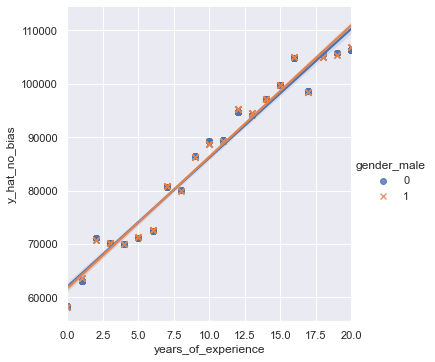

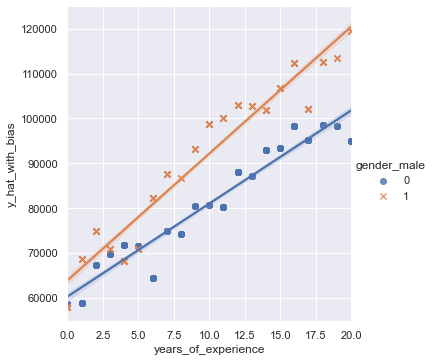

In [193]:
sns.lmplot(x="years_of_experience", y="y_hat_no_bias", hue="gender_male",  data=data_se, markers=["o", "x"],);
sns.lmplot(x="years_of_experience", y="y_hat_with_bias", hue="gender_male",  data=data_se, markers=["o", "x"],);

### EOF